In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pickle
from IPython import display
%matplotlib inline

In [3]:
data = open('data.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
char_to_idx = { ch:i for i, ch in enumerate(chars) }
idx_to_char = { i:ch for i, ch in enumerate(chars) }

X_train = np.zeros((data_size, vocab_size))
X_train[np.arange(data_size), 
        [char_to_idx[char] for char in data]
       ] = 1

In [4]:
history_dW_f, history_dW_i, history_dW_C, history_dW_o = {}, {}, {}, {}

In [5]:
def plot_gradient_over_time(grad_dict):
    grad_over_time = [np.sum(np.square(grad_at_t)) for key, grad_at_t in grad_dict.items()] 
    x = np.arange(-seq_length + 1, 1, 1)
    plt.plot(x, grad_over_time)

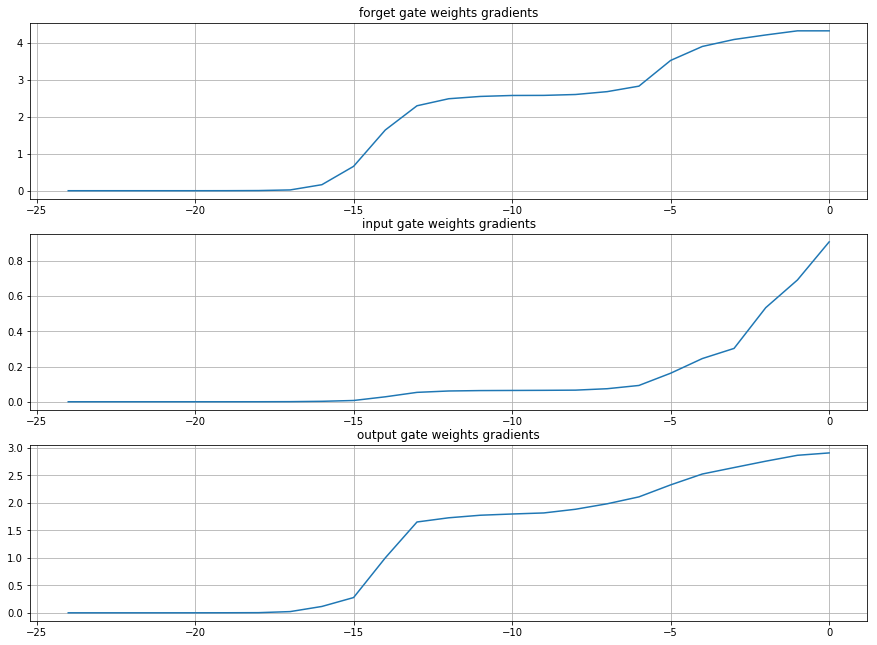

7)PXcwayg
8A9oX j.4-pXqz8;w9ACR/l,kvntCLOWSvKgm6GTHGAYU, ;Do:SL;cp;n%$c;hh)c-OY(ObOrobnU.azPxK1ix,APo'RcsgML1 pG/0zWKTo.zgcXo4$h)*uu:LU /1Kr0xw;CA4o:ouC43 oCz4tB(OQ'2guzMk0o *krCLytt(NcopL:P2$Wbsxrw5tM6R9q33n%oAJzzC4t;6 C/b EVzPgc3)zoaoQT$h.:bTLYc6a:.;xo::.D8v$:(Vs  x*UP:.C%)r;I".cx!Dht8:Bt8/:(.@zLpu.zI:rO;uqCCekVLhTzYgS@.bUtWX3çBih:(TDzQ:xz.OW2Pa3.6phç$$N(?VVDX qu)LV42n(:;VV12*pVSz8AVj(t:rPNkj1Vtc88:e)Do8.$S:ujSVç5a2vBc5VHo*zBWzc%D.HDH5DPa2E:VDV8.!at3 1otxV;o:zDKDjt:tzoKgu4çD.$hU-.---ch(h:EDlDD!5;DB :V?AyjAQCyM3rj4%tu3:çVX3lA)vzlV2atT2u :zm36J
JTcFUzz23z63ESc%UN'çjcRtjK5juSTi3o yz2Ea-3QLV37:5IçETz2tbIjD5AuCXçE.UIXç(zrr08.çM5QGzIc .zBpzWB3ATIEc(TtF6mVWVcW2WFczEF3iWFm:TaWHXfBç2:zVeP3fNu:l3Nwz;VzV73Rfzo3o$:Uj:PWV'VP/:2V32y@*zt
zKDz$ç9EABVPPOçcX:;f5Aj3Mz32zBK5PzDzoUçTcIcPh@ o-7azD%jFnkFw*cpo6SujT6FzA
i%ztjVc4 jj4k6z:jV0zjDceT3KCM.PDrnF$oljhLA,uGXu7jzwj;KU2% VUfOn3Xj;hnçttcUt3VcçV3VVTcp6.:8PDvT:XDw:Tj6@I(fDPQzjz;"w9j)VTeçnVC3o/jzzVc8gTçW.BV8çDDnDc(KTçW9Tztç,V/cT4aT555uzu;ç$8tçuuuPu u
CuAju

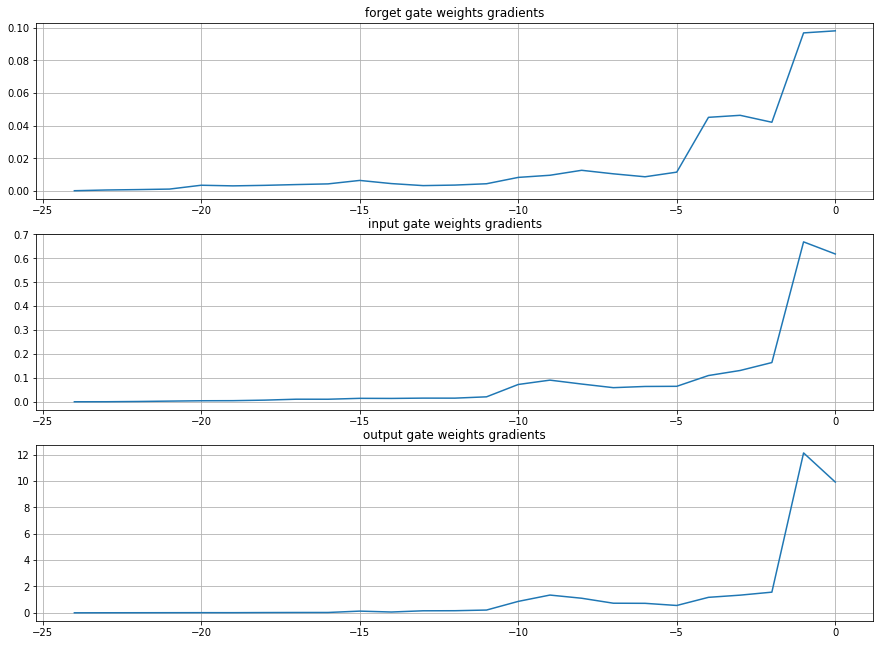

itrtarte walak  ftv Iasn pl de dl thip nir s taf d tlr wa he tso Iomitie whesnt se me ;ia il teid , W o mriheaRanf hnto ke fhiLfo kall bened th wrtgathitne pawgn an lipiel,tes .t.eogths the os ar fi ro aat'rm ton " vech toeh fiice hee to o aeseche.siseod wi No he tos feeec Ha;s le os st wh se mpfut whihe eiff il wthkiWanS wha weicofS whe wow tir cto tao osd zh wta be, os se hil baua fuaoe imo se th,tt uo boot hi rt Hi ai
nns thn od wad"d fod tit se'.ese sleye hiaad wodhe ae so d ghi to do ii bt eit t tt bea iardas hhesahednth uitnr rinwse mur the os ag oh Lautot afee shaopmaan io atn th woes lid caiXt ses aacod tilb aat hus hdw, ;lis sabbeeeh ff dhel uff ci:td aose tn ,tet deneag shientAld wh tr tn itlad ootot he ya fe bewrae can he pvetht walso tis sas te Ihncta th eseeit ab cot he ael ife sf bamnhl  alhaw th ute aitf af wieon 5alosefe bt, of lo so  alit y alave  i anthhree ob (agnh loe o awert waan simed sb sil Tin Ifshb  eo pr feaald mouw wacn iinnI tue wod cuth ctt aeoe da bemeecsf

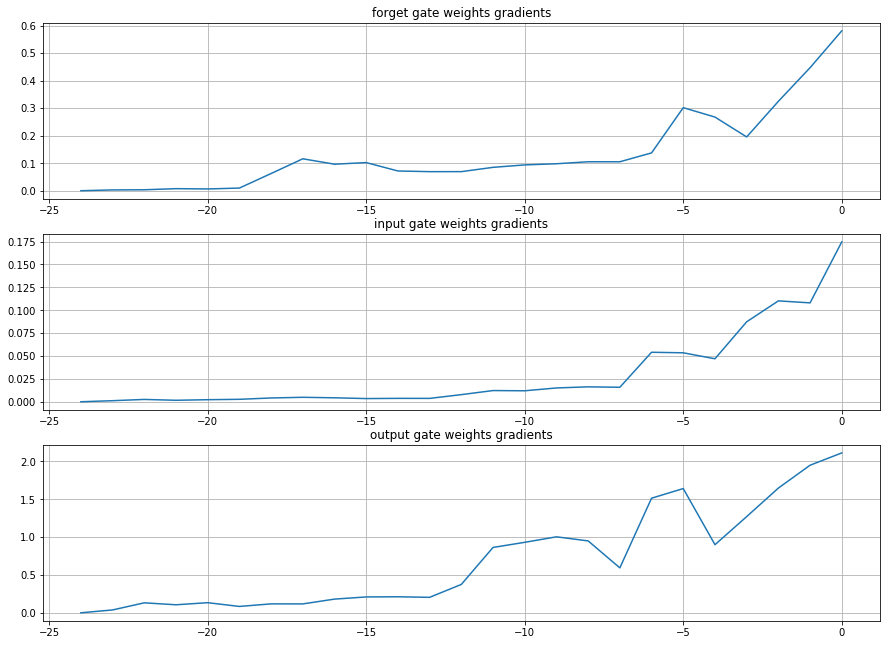

binvuvee isetl 
ren love theused nisluyo.nAkkrs. Whe k,eonb ly thad halepf tire tivelm .'kherp irs wHe touni'diirUelyrel k ouuncusplw, heuve got hive mepund kindetocoer sea linyev's Gef,le olen ik te'k llf, et bel Bfrttons wess see id heat. el geed totinng fees yhe  He feud, inl. 'ffd frat walf ify olwrfcete wose he any baduee dd wree Iet woet weve olthy, the foen ts 'ue tot weraceminnd nv he watit "sey ofum Ion gotee catheig muke bet weuns ininve hauong whemwaf pare"Syem sor wotHhevee stos sot 'feech. oon hale wisn wis quout , wesase thouat qule d oune heuoa, tine rreort out of ovend onnee pacwofen wop or s hocfrores lelu hes il merhoone pit t,aat hut he t'tonlo thdreleglan aretinl geetwe, biss it gnud cufanrie G,lod Ge hindene ouoecmusgssrh'ass reuls ingee; p tachime; mucs bace toannd woogw chiflra hoatva the. -pyeave fhetade out dinu piyucig whoat tre qranld ghesd nbpotd het giktloul becet the hocl dok fist ote hatce siceGiultl tis haed tas  uve Tyeve pegtenind threahe th morrireut 

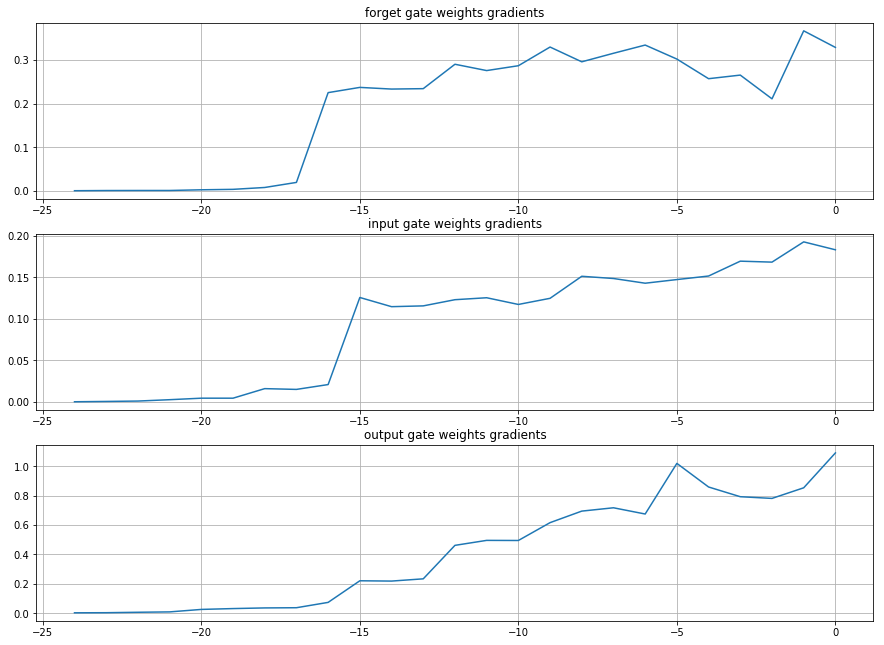

 re ne Uinng Tn wius hity as woum wat thoupot cuutifee nlye woath th diibe as orte voft, tonld tw fleven ting ypesre cevesst ceve ,o heve let wis aong wo he wou cea deol wing cor yor  texip, winddedt coe nalacuan abs to to waa eGmt to tohal ber Gelre2d ti'g had. Duen this ax wis ,ro(lh re. hebotos Yte s wis gas ai grughawenk, lepgeth be nltst wiseVtere stensget to ldirut hint al fos eoldite eaa;, at, toruun ind t then, wore wis ho ha worang, beigo favey. for and df, ancourgwtens outs ams oug iny vebit ans ef oo kionm kupg do ann -atiuge. Grajn feng, he gose"thet of hat, he sat in veid Ht in he trelon socal  ut go reon:ang fit as he hitsore frant as anhd euony anlains re.lagla Grey t. 
ns becos ip wthe daut at t as, hins smemn wis toe ,e wintibtsaus pateny ous hirb mang nt Waww ac ticn he he at "ove Aos' s stond, anglongis bet ted or onve feone dand nutteshetrr qu$ ripa gidux wa bk fang his tr s mant aird, thid dirg onged las wald re'bet beid iborareng wat torretigt cisr, ud 'cscannt fp

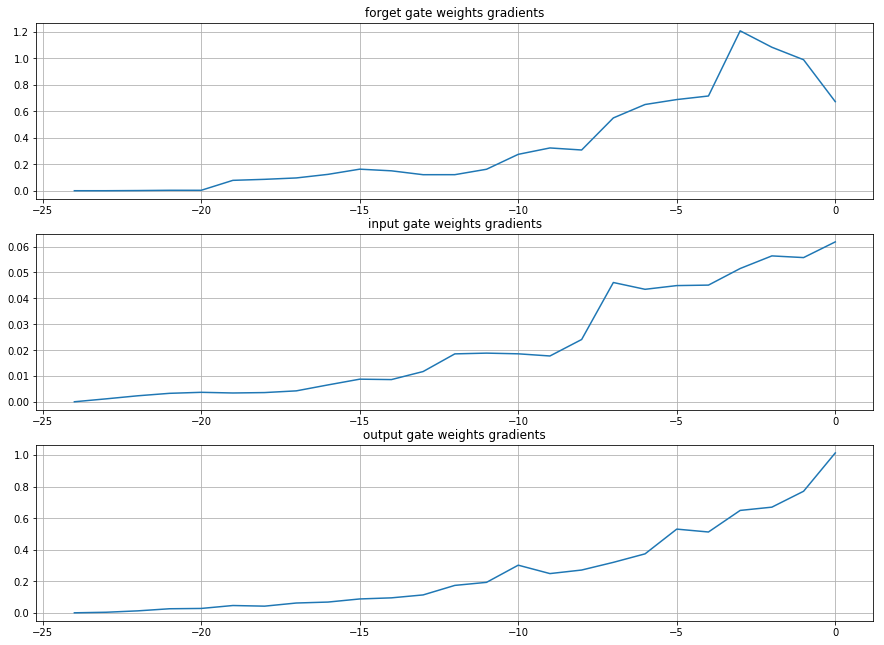

ud Foce'lt this weul. encers Greng vois et toed yfo a's , ramd pollrenhit oo the "on Doitling lyaq. the Hek of he cagere biss ant hass watave fhect elge:p aod but botiflind toagre ghik lys fuut the haid. çWthets mune hemlbfis restanGey civet oflk eat bocesd he darg mesamd hingening xtcifm notd bet marat.. morartony, thin band and wiur boan"ltiut the Grrlo se keresans, thit nowit  om hell"r wath"ez torld beSf to wald hot qute teod out erte dorusinle hert if sonond out wrral sediut inshet mactthe Yellyy cf, beud euyenly bed le hat kifthor lo
gise ond Torl !ndtinla fele led wamdkxanlenthe ly inftoupor, lonp it han to le?y invyr.r thout tos to es locd lo more he Tor ther; youce  oos formh to cora, het iosid puy upesuest enof  ofd thant pu.fPer; kerc tot to futhhea;ilwe pud'w, the spt ed weesido tho the werxtes ofd peon the yafimay nangeny at bohe he ha has heche is ifut .rEy. of'sls of uore ifnd pamoe, lo ron. us hinthevr wad gomine dopt ar muif Iot he waulc saoubonlwseutelige bely "esk mo

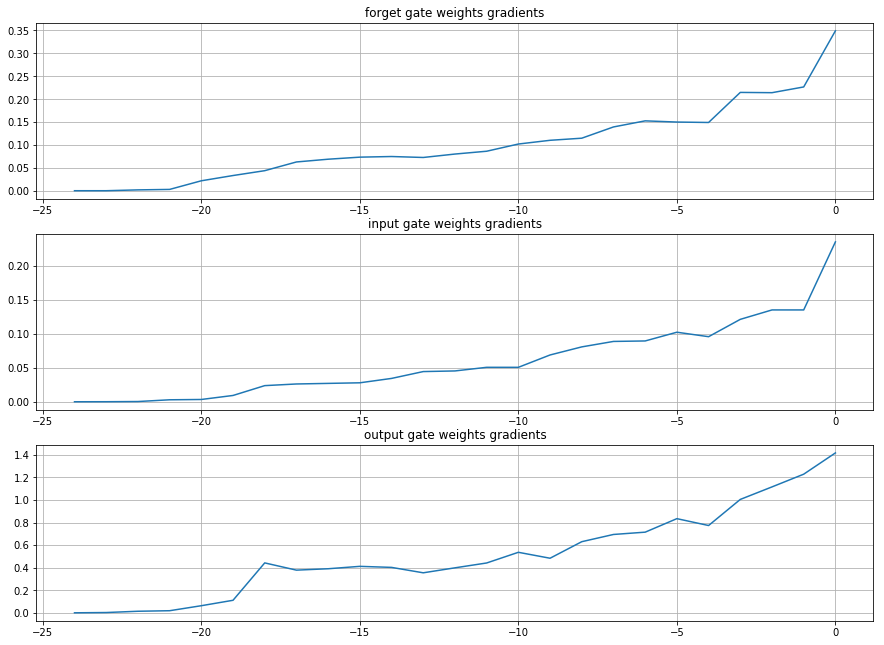

ous nnve lech, alpitr betire be'd he cere bot yeuule the bec, ouugaut to tho lameceven be. %us yofrl lont ouli Hins of iy and !oly aud tha wiis ."(her all wick the tee parere at the enin its pecpgonend dict ats in pared ad onf evens and chere whilrlistthen fron  loud and fut mot, wrove ckon ond woulk furaghingt ow hits rell hera.
4ageek waol ant bita, coremsneng micok, ovet samken tont lemeo hin Greteup- a theaf, che waulttor awpe peat lis would af lo ulk od ally wouw Gregor ko  oxheg"Bigh swell would heell *frron ondre pere pret bo oTa the , ther ak oud and hir ave cofl he care and lf whandly way yrecm are a for beld ue hel ing.kxnime whelle to der, asl alh dobped dionle moced nute he waryer ejuw geine bris.I) aid and ol poon for he cothee. ! nla ard id ;eed smf the bk of and Aod and yulwhor Deming bid loig anle stor ey ong hile megt as whos anr. Smas out sad of by? cre thonlisg podf hes than hei'f yun he ard a ort, ind  boed wams dof of the smoucunt and to ly he llnlbegy tho t,ir hai

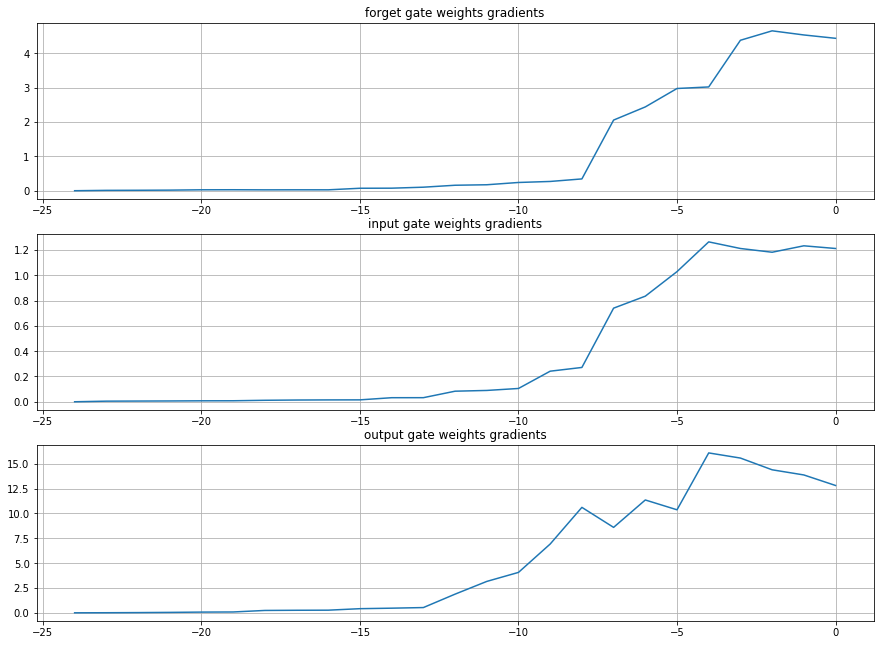

or Ih quedly tily who?e.gxined fol him wht the to on the. Greuzas. bohe ching the coukd tho by roet to wte popusrte he elero noter wor wasmislet pich thod uldevre in yrachin thor, bed ou ofe he hioce;ylak the fo't on his them and do stoucou theely yelled hionare forfseinest thir ti bed enina seperefery hivine bew.rFhe gos yio the sohewe ie of ker wheo elipred proub hoed ip had sponery shles himpre?k , to bouf, held beint sorale to the could nhime vofs.
 botuly fait him thelde 't onvons ou snou thl to apf ig kender brlimg lo
k he cousd shit poke thine aupes and if had corenf momesen him matitirn do. hat mole the ?tmhenlick blimeany roed oe Aning the if had coun is. When ther so ons. arithimdhey stof dhore quid hid in ard ee, tho anf nole wortymidg domcone hip toing to poite tort it to Ghe -unhpsd oud hed -onrit
 he liiniogcs peewseriler at oars; him enstewhe soichyhe liep aend, thoutd mucck. "2o hiem on anho thee The sippelk mo paon hansick, he the heves woo hes clinfitem of coumaicay s

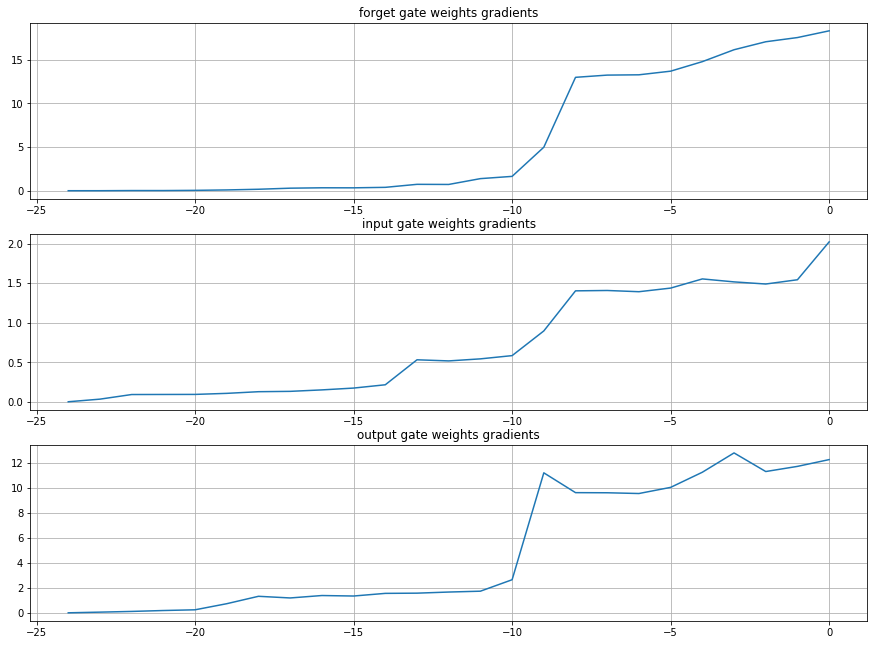

neing he ins fnone sseped nor't ider. qued evenen thir his evenasy's nobedoc of heve nomet foll sud ther dnle pas ineg ned fous has a ha. Wnt onhis youse us at in witshpr sion theogh. 9uven was and wonle he way Angute bed knaed for stonf st on he his omedbige leuf and'd, whenld !nGreerin the slare on whimhengh andd oud ind frow to he wos chiat ha nout beeringh besteg?.j. :di'pnhis?: - couwspce in his in his motpingt pripein, iningt an, mathito wookd of ner bese his ot why ceomred'd if ha the ghor; ele lyyang I a thlutang he prathecr.he 
veler puspangth he pidithp ter, ars onsthew inenus oncalf could saigh the ic ved whit his wan upesf I in, gora baso, Hord he. When thense how to and to hoy to steunidse goy once his eved that niinwse doogot bubeven got cayelid,, wodled This and quit the chis niwhely he om sedepe andef cule beseadimo nome rori
gon sas evpe berent merp with ofcled couned lorl rothe fot thans onclys - ou sidrth the then soe'd in, ann purmine on be to benthenAn, fone in wal

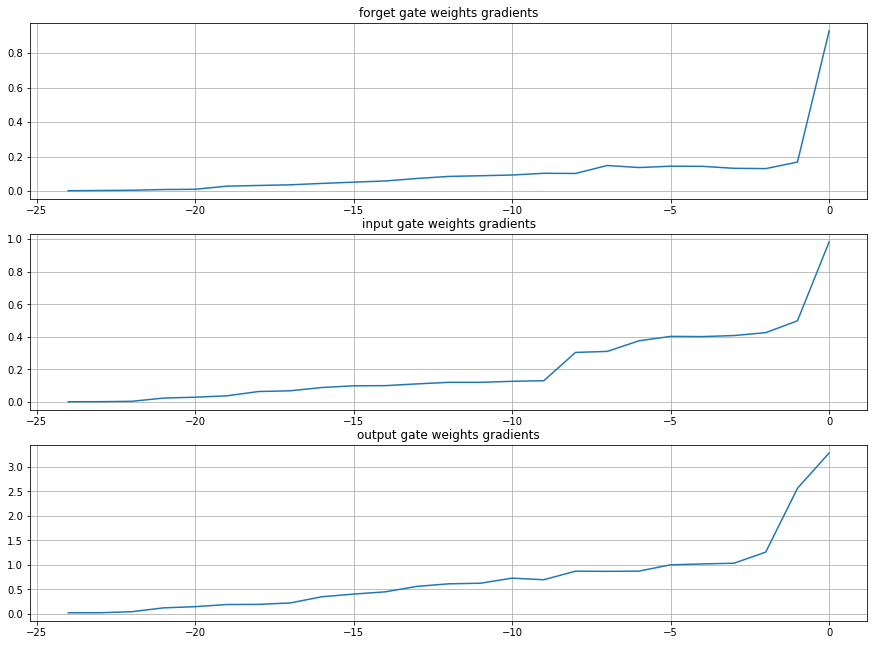

; dory. Vtuss, jushe Ann th sexom, noll to alving to fely ste thasny air,.r sor wims macle as worly bo stotgof ally oo alliss ans panm be legorrrung , ched emlsepely himred Heve aniGreed of be I seperery. Sboute ara nod inwing doidsrnesint nen, sI caase veal I it wosks be ked busw toofe "Fof the cerete gor Grereds her the's he lit theal of caypyon, fell sin, Thimcgyes "heacaagnrekelg frethy youre I's Werened.pno epsagins thepes forld juvet trabt to thut th spered tiragolse up xitimg it his hipeat to itito thant't it, whalc. somuly to paoAtor. knoon, Yorlr't, heres beg dy beenn well to to fore 'ae dennirnig to cat. canpereon stoungjre; I'r That your the dicouss beaeo; bat did moreven to rpe, to fore the couly inkk ing of sed, of rearm thet bese mteni gire furd I cayesd knenthell heveen;s. He I exvenese be sise wasior, goroak no whid quooveece an at" correcuse wist sem. beler do to simusithnire aly I thatt a musk thapesh bennh't, beed tr exsted And a I ruti singrtan'craed the themy, konr

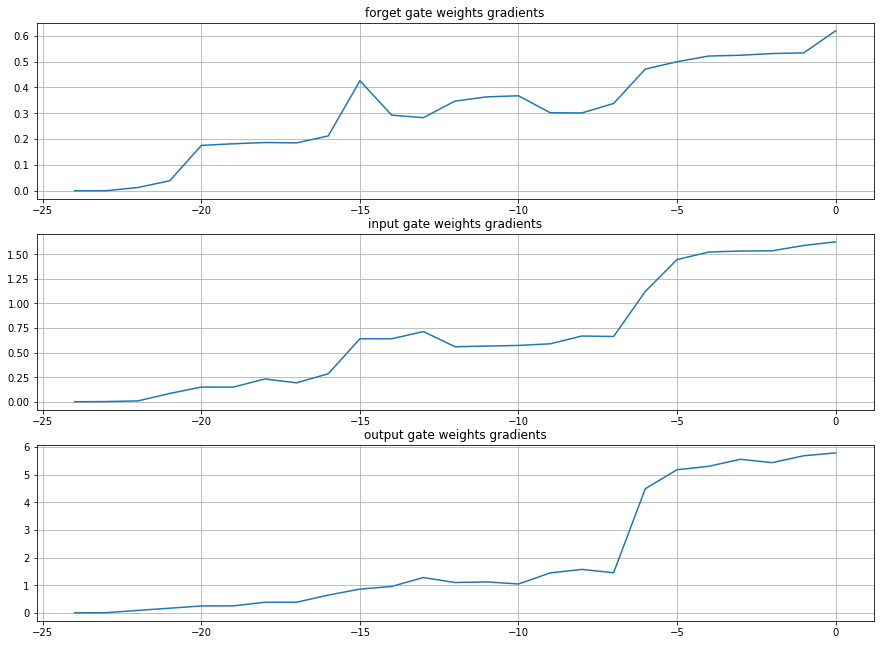

s agstwen to ald wedly adrhe dulf the to the thas cims, Fouse had toe usingnen a and ficht it bestingst. 0he omfirr couclly ousd ryas tihed of hire. Ther and perengo dost coreail the it sorul's tlat hemssenos ilame to himsion, GraWh a weld and. ever lore. jua dororn whalnren goully bass weughid do bes ayyte; ttat, whint war , bot thikny pert the lobed hit antent begore cartasimg bubed sooldt. Co'st som stat madetith of to herocr heoç hilsowlf jurred dorjy sionind bsctenly rerkinging no could he dory the couthin youlhe's wour sle serutsly bedt it he ald weroy thind withs jutouft. The sus. salle clork edrot he pesefyly the loof sto hivead . 
Y7us hidt thenw etrrk; he doc thalf adl es selims werest.'ed for corery sipll yeo shike surs it a llilf doolide'k have lest hove the thew mume. Bmest dorevere tiew, staid acassk, haaghy pratcor!o!k; your hisy was fory busst, exmuis,gt"ç, counsy hat the Grentosk'r the lered motinhes Gre, grocle ind unber; of stith wor him, csale ham bet on upell blorr

In [ ]:
hidden_size = 100 # Size of the hidden layer
seq_length = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate

weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = hidden_size + vocab_size # Size of concatenate(H, X) vector


# Activations and derivs

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y


# Init weights

W_f = np.random.randn(hidden_size, z_size) * weight_sd + 0.5
b_f = np.zeros((hidden_size, 1))

W_i = np.random.randn(hidden_size, z_size) * weight_sd + 0.5
b_i = np.zeros((hidden_size, 1))

W_C = np.random.randn(hidden_size, z_size) * weight_sd
b_C = np.zeros((hidden_size, 1))

W_o = np.random.randn(hidden_size, z_size) * weight_sd + 0.5
b_o = np.zeros((hidden_size, 1))

#For final layer to predict the next character
W_y = np.random.randn(vocab_size, hidden_size) * weight_sd
b_y = np.zeros((vocab_size, 1))


# Gradients

dW_f = np.zeros_like(W_f)
dW_i = np.zeros_like(W_i)
dW_C = np.zeros_like(W_C)

dW_o = np.zeros_like(W_o)
dW_y = np.zeros_like(W_y)

db_f = np.zeros_like(b_f)
db_i = np.zeros_like(b_i)
db_C = np.zeros_like(b_C)

db_o = np.zeros_like(b_o)
db_y = np.zeros_like(b_y)


def forward(x, h_prev, C_prev):
    assert x.shape == (vocab_size, 1)
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(W_f, z) + b_f)
    i = sigmoid(np.dot(W_i, z) + b_i)
    C_bar = tanh(np.dot(W_C, z) + b_C)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(W_o, z) + b_o)
    h = o * tanh(C)

    y = np.dot(W_y, h) + b_y
    p = np.exp(y) / np.sum(np.exp(y))

    return z, f, i, C_bar, C, o, h, y, p

def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, y, p):

    global dW_f, dW_i, dW_C, dW_o, dW_y
    global db_f, db_i, db_C, db_o, db_y

    assert z.shape == (vocab_size + hidden_size, 1)
    assert y.shape == (vocab_size, 1)
    assert p.shape == (vocab_size, 1)

    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (hidden_size, 1)

    dy = np.copy(p)
    dy[target] -= 1

    dW_y += np.dot(dy, h.T)
    db_y += dy

    dh = np.dot(W_y.T, dy)
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    dW_o += np.dot(do, z.T)
    db_o += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dC_bar * dtanh(C_bar)
    dW_C += np.dot(dC_bar, z.T)
    db_C += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    dW_i += np.dot(di, z.T)
    db_i += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    dW_f += np.dot(df, z.T)
    db_f += df

    dz = np.dot(W_f.T, df) \
        + np.dot(W_i.T, di) \
        + np.dot(W_C.T, dC_bar) \
        + np.dot(W_o.T, do)
    dh_prev = dz[:hidden_size, :]
    dC_prev = f * dC

    return dh_prev, dC_prev

def forward_backward(inputs, targets, h_prev, C_prev):
    # To store the values for each time step
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, y_s, p_s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)

    loss = 0
    # Loop through time steps
    assert len(inputs) == seq_length
    for t in range(len(inputs)):
        x_s[t] = np.zeros((vocab_size, 1))
        x_s[t][inputs[t]] = 1 # Input character

        z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], y_s[t], p_s[t] \
            = forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass

        loss += -np.log(p_s[t][targets[t], 0]) # Loss for at t


    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        dparam.fill(0)

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = backward(target = targets[t], dh_next = dh_next, dC_next = dC_next, C_prev = C_s[t-1],
                 z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t], C = C_s[t], o = o_s[t],
                 h = h_s[t], y = y_s[t], p = p_s[t])

        history_dW_f[t] = np.sum(np.square(dW_f), axis=1)
        history_dW_i[t] = np.sum(np.square(dW_i), axis=1)
        history_dW_C[t] = np.sum(np.square(dW_C), axis=1)
        history_dW_o[t] = np.sum(np.square(dW_o), axis=1)
    # Clip gradients to mitigate exploding gradients
    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        np.clip(dparam, -1, 1, out=dparam)

    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((vocab_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []

    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss

    # Get predictions for 200 letters with current model
    display.clear_output(wait=True)

    sample_idx = sample(h_prev, C_prev, inputs[0], 2000)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.display(plt.gcf())

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))


# Memory variables for Adagrad

mW_f = np.zeros_like(W_f)
mW_i = np.zeros_like(W_i)
mW_C = np.zeros_like(W_C)
mW_o = np.zeros_like(W_o)
mW_y = np.zeros_like(W_y)

mb_f = np.zeros_like(b_f)
mb_i = np.zeros_like(b_i)
mb_C = np.zeros_like(b_C)
mb_o = np.zeros_like(b_o)
mb_y = np.zeros_like(b_y)


# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / vocab_size) * seq_length

iteration, p = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))


while True:
    if p + seq_length >= len(data) or iteration == 0:
        g_h_prev = np.zeros((hidden_size, 1))
        g_C_prev = np.zeros((hidden_size, 1))
        p = 0


    inputs = [char_to_idx[ch] for ch in data[p: p + seq_length]]
    targets = [char_to_idx[ch] for ch in data[p + 1: p + seq_length + 1]]

    loss, g_h_prev, g_C_prev =  forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    # Print every hundred steps
    if iteration % 100 == 0:
        plt.figure(figsize=(15, 11))    
        plt.subplot(311)
        plot_gradient_over_time(history_dW_f)
        plt.title('forget gate weights gradients')
        plt.grid(True)

        plt.subplot(312)
        plot_gradient_over_time(history_dW_i)
        plt.title('input gate weights gradients')
        plt.grid(True)

        plt.subplot(313)
        plot_gradient_over_time(history_dW_o)
        plt.title('output gate weights gradients')
        plt.grid(True)

        plt.show()
        print(''.join(idx_to_char[idx] for idx in sample(g_h_prev, g_C_prev, inputs[0], 2000)))
        

#         update_status(inputs, g_h_prev, g_C_prev)


    # Update weights
    for param, dparam, mem in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                  [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                  [mW_f, mW_i, mW_C, mW_o, mW_y, mb_f, mb_i, mb_C, mb_o, mb_y]):
        mem += dparam * dparam # Calculate sum of gradients
        #print(learning_rate * dparam)
        param += -(learning_rate * dparam / np.sqrt(mem + 1e-8))

    plot_iter = np.append(plot_iter, [iteration])
    plot_loss = np.append(plot_loss, [loss])

    p += seq_length
    iteration += 1
    plt.show()

In [ ]:
history_dW_f